In [1]:
import torchdata.datapipes as dp
from torch.utils.data import DataLoader
import torch.nn as nn
import torch
import numpy as np
import ot
import matplotlib.pyplot as plt
import timeit


In [2]:
device = torch.device('cpu')

noise_size = 62

# Number of training epochs
num_epochs = 1

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

ngpu = 0

weight_cliping_limit = 0.01

batch_size = 1024

test_batch_size = 65536

w_dim = 5

data_dim = int(w_dim*(w_dim - 1)//2)

In [3]:
def row_processer(row):
    return np.array(row, dtype= np.float32)

filename = f"samples/samples_{w_dim}-dim.csv"
datapipe = dp.iter.FileOpener([filename], mode='b')
datapipe = datapipe.parse_csv(delimiter=',')
datapipe = datapipe.map(row_processer)

In [4]:
dataloader = DataLoader(dataset=datapipe, batch_size=batch_size, num_workers=2)

In [5]:
d = next(iter(dataloader))
print(d)
print(d.shape)
if d.size(1) != data_dim + w_dim:
    print("!!!!!!!!!!!!!!!!!!!!!!!!! WRONG DATA DIMENSIONS !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")

tensor([[ 0.5620,  0.2631, -0.5968,  ..., -0.1593,  0.0411,  0.3750],
        [ 0.5172, -0.1408, -1.2289,  ..., -0.1234, -0.0321, -0.0301],
        [ 1.4155,  1.1087,  0.6902,  ...,  1.4033,  0.3446,  0.6978],
        ...,
        [-0.6558,  0.7509,  1.6546,  ...,  0.7923, -0.4857,  0.7040],
        [-1.3328,  0.8035,  0.4257,  ...,  0.4013, -0.1146, -0.1568],
        [-1.9890, -1.5622,  0.4765,  ..., -0.2772,  0.2376,  0.0805]])
torch.Size([1024, 15])


In [6]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    if classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0.0)

In [7]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(w_dim+noise_size,512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512,512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512,128),
            nn.BatchNorm1d(128),
            nn.ReLU(),

            nn.Linear(128,data_dim)
        )

    def forward(self, input):
        return self.main(input)

In [8]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(w_dim + data_dim,512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),

            nn.Linear(512,512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),

            nn.Linear(512,128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2),

            nn.Linear(128,1),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [9]:
netD = Discriminator().to(device)
netD.apply(weights_init)
netG = Generator().to(device)
netG.apply(weights_init)

Generator(
  (main): Sequential(
    (0): Linear(in_features=67, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=128, bias=True)
    (7): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [10]:
optG = torch.optim.Adam(netG.parameters(),lr = lr, betas=(beta1,0.999))
optD = torch.optim.Adam(netD.parameters(), lr = lr, betas=(beta1,0.999))

W_fixed: torch.Tensor = torch.tensor([1.0,-0.5,-1.2,-0.3,0.7,0.2,-0.9,0.1,1.7])
W_fixed = W_fixed[:w_dim].unsqueeze(1).transpose(1,0)
W_fixed = W_fixed.expand((test_batch_size,w_dim))

test_filename = f"samples/fixed_samples_{w_dim}-dim.csv"
A_fixed_true = np.genfromtxt(test_filename,dtype=float,delimiter=',',)
A_fixed_true = A_fixed_true[:,w_dim:(w_dim+data_dim)]

wass_errors = []

iters = 0

one = torch.FloatTensor([1])
mone = one * -1

In [11]:
for epoch in range(num_epochs):

    for i, data in enumerate(dataloader):
        netD.zero_grad()

        for p in netD.parameters():
            p.data.clamp_(-weight_cliping_limit, weight_cliping_limit)


        b_size = data.size(0)

        out_D_real = netD(data)
        lossDr = out_D_real.mean(0).view(1)
        lossDr.backward(one)

        W = data[:,:w_dim]
        A_real = data[:,w_dim:(w_dim + data_dim)]
        noise = torch.randn((b_size,noise_size), dtype=torch.float, device=device)
        gen_in = torch.cat((noise,W),1)
        generated_A = netG(gen_in)
        fake_in = torch.cat((W,generated_A.detach()),1)

        lossDf = netD(fake_in)
        lossDf = lossDf.mean(0).view(1)
        lossDf.backward(mone)
        lossD = lossDr - lossDf
        optD.step()

        if i%10==0:
            netG.zero_grad()

            fake_in = torch.cat((W,generated_A),1)
            lossG = netD(fake_in)
            lossG = lossG.mean(0).view(1)
            lossG.backward(one)
            optG.step()

        if iters%100 == 0:

            noise = torch.randn((test_batch_size,noise_size), dtype=torch.float, device=device)
            g_in = torch.cat((noise,W_fixed),1)
            A_fixed_gen = netG(g_in).detach().numpy()
            errors = [ot.wasserstein_1d(A_fixed_true[:,i],A_fixed_gen[:,i],p=2) for i in range(data_dim)]
            pretty_errors = ["{0:0.4f}".format(i) for i in errors]
            print(f"epoch: {epoch}/{num_epochs}, iter: {iters},\n errors: {pretty_errors}")
            wass_errors.append(errors)

        iters += 1

epoch: 0/1, iter: 0,
 errors: ['0.0809', '0.1127', '0.0050', '0.0172', '0.1648', '0.0347', '0.1888', '0.0768', '0.0639', '0.0029']
epoch: 0/1, iter: 100,
 errors: ['0.0722', '0.0810', '0.0050', '0.0066', '0.1457', '0.0694', '0.1981', '0.0734', '0.0409', '0.0239']
epoch: 0/1, iter: 200,
 errors: ['0.0735', '0.0769', '0.0184', '0.0065', '0.1443', '0.0865', '0.1913', '0.0673', '0.0436', '0.0506']
epoch: 0/1, iter: 300,
 errors: ['0.0739', '0.0812', '0.0084', '0.0102', '0.1408', '0.0646', '0.1988', '0.0670', '0.0376', '0.0322']
epoch: 0/1, iter: 400,
 errors: ['0.0764', '0.0831', '0.0225', '0.0112', '0.1217', '0.0539', '0.1689', '0.0542', '0.0398', '0.0390']
epoch: 0/1, iter: 500,
 errors: ['0.0641', '0.0958', '0.0347', '0.0090', '0.1111', '0.0930', '0.1492', '0.0579', '0.0318', '0.0323']
epoch: 0/1, iter: 600,
 errors: ['0.0602', '0.0933', '0.0197', '0.0118', '0.1015', '0.0849', '0.1657', '0.0619', '0.0314', '0.0302']
epoch: 0/1, iter: 700,
 errors: ['0.0667', '0.0921', '0.0181', '0.0189'

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


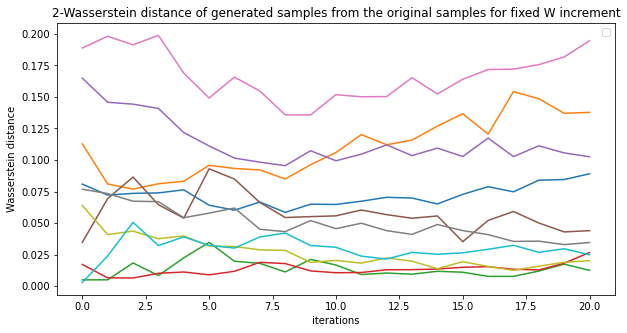

In [12]:
plt.figure(figsize=(10,5))
plt.title("2-Wasserstein distance of generated samples from the original samples for fixed W increment")
plt.plot(wass_errors)
plt.xlabel("iterations")
plt.ylabel("Wasserstein distance")
plt.legend()
plt.show()

In [13]:


for i in range(data_dim):
    true_col = A_fixed_true[:,i]
    generated_col = A_fixed_gen[:,i]
    dist = ot.wasserstein_1d(true_col,generated_col,p=2)
    print(dist)

0.08908106917858455
0.13774727724866473
0.012527513446953239
0.026671986714016254
0.10256036500038915
0.043994104617039786
0.1945408933736602
0.03461292178853844
0.020228675943454632
0.024874357789166086


In [16]:
W_fixed: torch.Tensor = torch.tensor([1.0,-0.5,-1.2,-0.3,0.7,0.2,-0.9,0.1,1.7])
W_fixed = W_fixed[:w_dim].unsqueeze(1).transpose(1,0)
W_fixed = W_fixed.expand((test_batch_size,w_dim))
noise = torch.randn((test_batch_size,noise_size), dtype=torch.float, device=device)
g_in = torch.cat((noise,W_fixed),1)
netG.eval()
start_time = timeit.default_timer()
for i in range(100):
    A_fixed_out=netG(g_in)

elapsed = timeit.default_timer() - start_time
print(elapsed)

34.215258249001636


Takes 34.2s to generate 6553600 samples (original GAN)
Calling iterated_integrals(h = 1.0, err = 0.0005) 6553600-times takes 100.5s